In [13]:
import pandas as pd
import os
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import proplot as pplt
from natsort import natsorted
import torch
from tqdm import tqdm
from twaidata.torchdatasets.DirectoryParser3DMRIDataset import *
from trustworthai.journal_run.evaluation.new_scripts.eval_helper_functions import *

In [2]:
lbc_ds = LBCInterRaterDataset()

In [3]:
xs, ys, ind = lbc_ds[0]

In [4]:
ind

'LBC360007'

In [5]:
xs.keys()

dict_keys(['mask', 'FLAIR', 'T1'])

In [6]:
ys.keys()

dict_keys(['wmh', 'wmh_flthresh'])

In [7]:
vol1 = []
vol2 = []
dice = []
for (xs, ys, ind) in tqdm(lbc_ds):
    if 'wmh_flthresh' in ys.keys():
        wmh1 = ys['wmh'].cuda()
        wmh2 = ys['wmh_flthresh'].cuda()
        vol1.append(wmh1.sum().item())
        vol2.append(wmh2.sum().item())
        dice.append(fast_dice(wmh1, wmh2))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.81it/s]


In [8]:
df = pd.DataFrame({
    "WMH1_mm3":torch.Tensor(vol1) * 0.003,
    "WMH2_mm3":torch.Tensor(vol2) * 0.003,
    "DSC":torch.Tensor(dice)
})

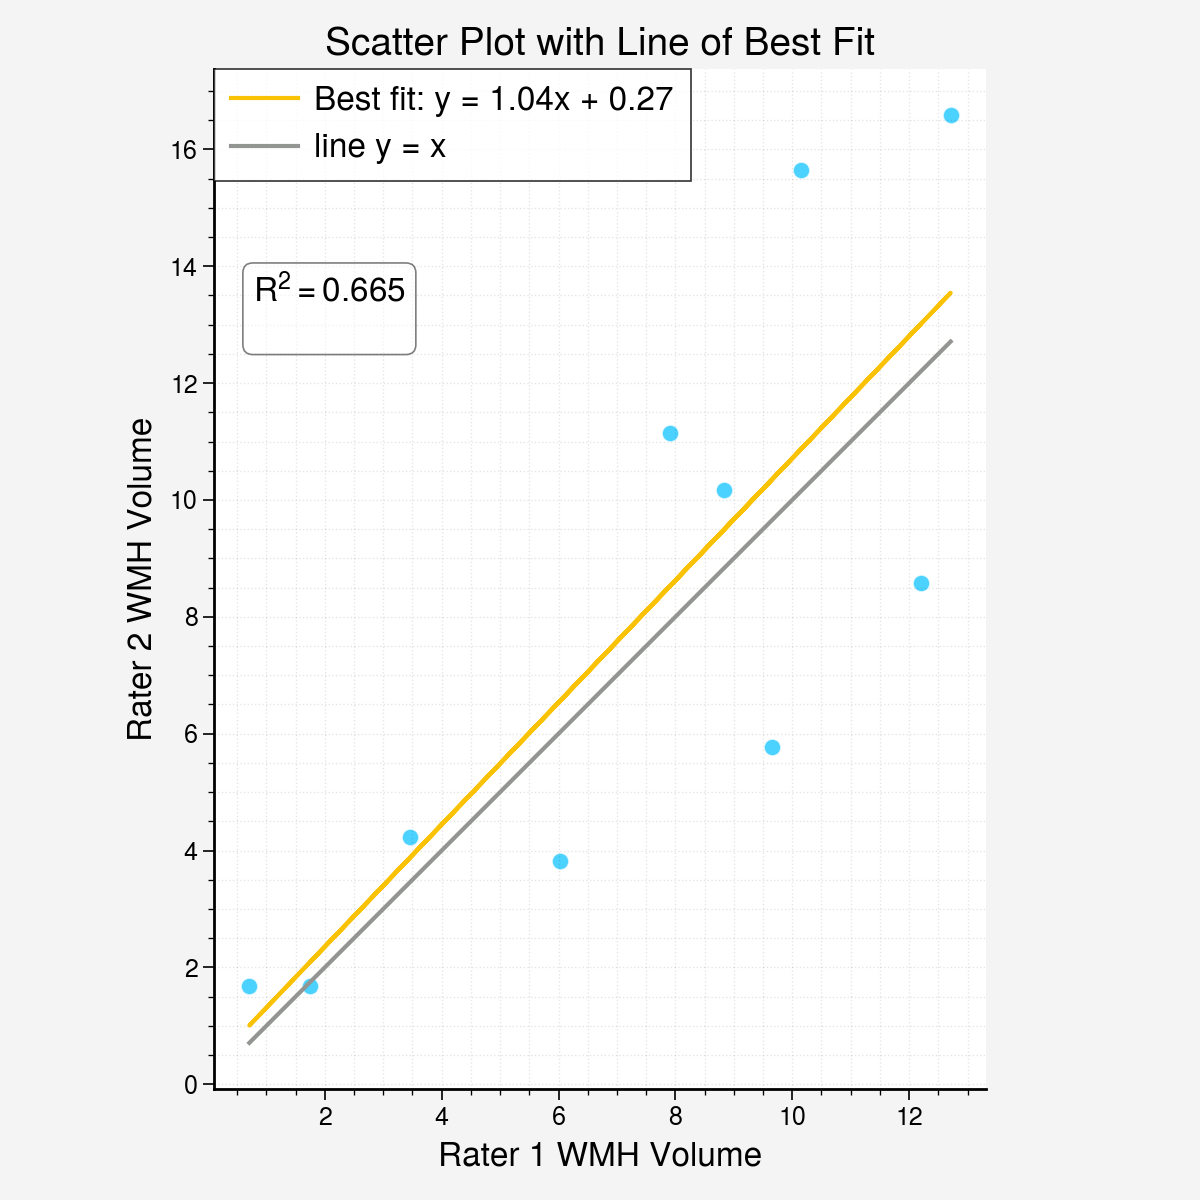

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Example data
x = df["WMH1_mm3"]
y = df["WMH2_mm3"]

# Calculate line of best fit
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

# Create scatter plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, y, color='deepskyblue', alpha=0.7, edgecolors='w', linewidth=0.5)

# Plot line of best fit
plt.plot(x.values, line.values, color='goldenrod', label=f'Best fit: y = {slope:.2f}x + {intercept:.2}')
plt.plot([min(x), max(x)], [min(x), max(x)], color='gray', label=f'line y = x')

# Annotate with text (R^2 and line equation)
plt.text(0.05, 0.80, f'$R^2 = {r_value**2:.3f}$\n', transform=plt.gca().transAxes,
         fontsize=12,  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Enhance aesthetics
plt.title('Scatter Plot with Line of Best Fit', fontsize=14, )
plt.xlabel('Rater 1 WMH Volume', fontsize=12, )
plt.ylabel('Rater 2 WMH Volume', fontsize=12, )
plt.legend(fontsize=12)

plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()


# Remove right and top spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make left and bottom spines thicker
ax.spines['left'].set_linewidth(1.)
ax.spines['bottom'].set_linewidth(1.)

ax.set_aspect('equal', adjustable='box')

plt.tight_layout()    

# Show plot
plt.show()


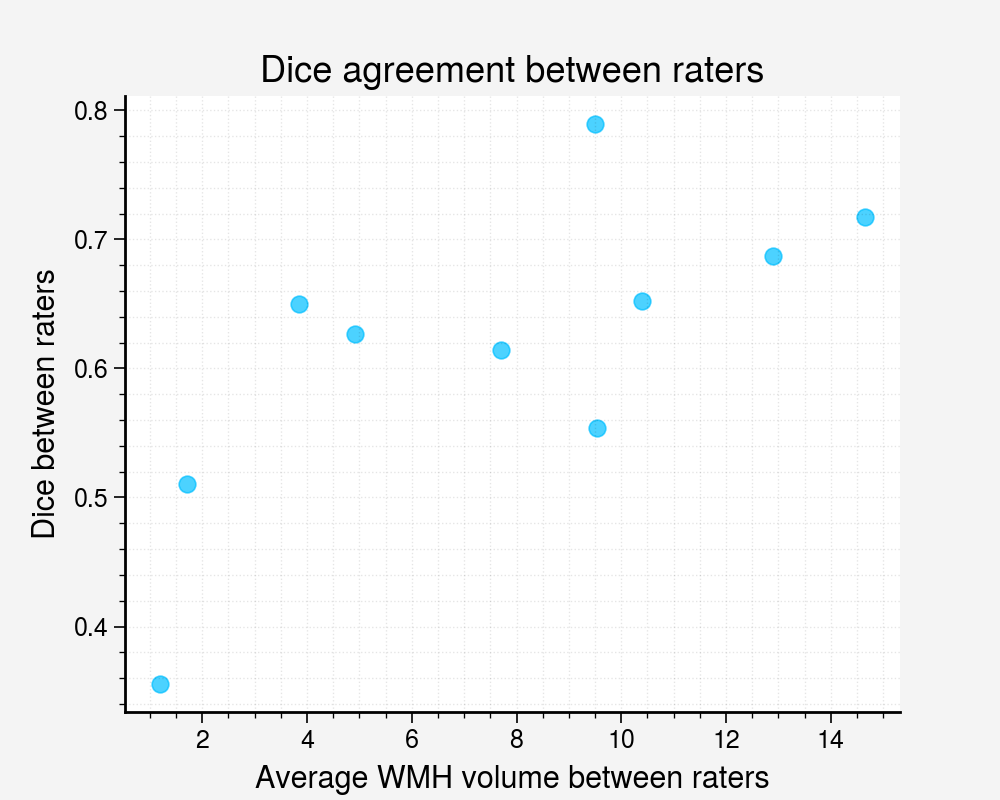

In [10]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(5, 4))
y = df["DSC"]
x = (df["WMH1_mm3"] + df["WMH2_mm3"]) / 2
ax.scatter(x, y, alpha=0.7, c='deepskyblue')

# annotation
plt.title("Dice agreement between raters", fontsize=13)
plt.xlabel("Average WMH volume between raters", fontsize=11)
plt.ylabel("Dice between raters", fontsize=11)

# point out influential outliers
for (xi, yi) in zip(x, y):
    if xi > 8000 and yi < 0.5:
        scatter = ax.scatter(xi, yi, facecolors='none', edgecolors='orange', linewidth=1, s=100, linestyle=':')
        ax.text(xi + max(x) * 0.02, yi, 'Low Dice Outlier', verticalalignment='center', horizontalalignment='left', color='goldenrod')
for (xi, yi) in zip(x, y):
    if xi < 15000 and yi > 0.9:
        scatter = ax.scatter(xi, yi, facecolors='none', edgecolors='green', linewidth=1, s=100, linestyle=':')
        # ax.text(xi + max(x) * 0.02, yi, 'Low Dice Outlier', verticalalignment='center', horizontalalignment='left')
ax.text(13000, 1, 'High Dice Outliers', verticalalignment='center', horizontalalignment='left', color='green')

# grid
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()


# Remove right and top spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Make left and bottom spines thicker
ax.spines['left'].set_linewidth(1.)
ax.spines['bottom'].set_linewidth(1.)

# plt.tight_layout()

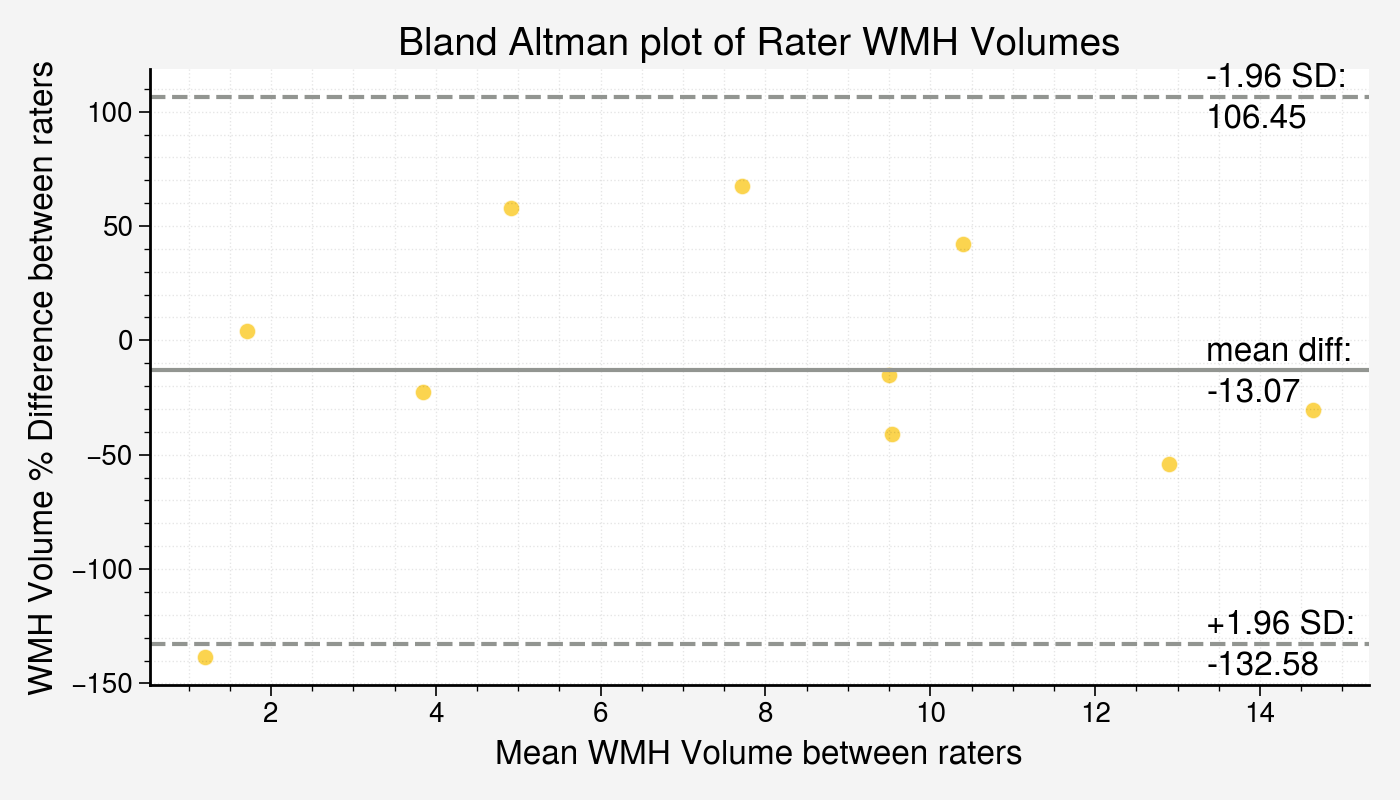

In [11]:
x = df["WMH1_mm3"]
y = df["WMH2_mm3"]
diff = (x - y)
percent_diff = 100 * diff / np.minimum(x, y)
mean_percent_diff = np.mean(percent_diff)
mean = (x + y) / 2
std = np.std(percent_diff, ddof=1)
conf_bound_95 = 1.96 * std

fontsize = 12

fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(mean, percent_diff, color='goldenrod', alpha=0.7, edgecolors='w', linewidth=0.5)

# mean and 95% confidence lines
ax.axhline(y=mean_percent_diff, color='gray')
rhs_point = max(x) * 1.05
ax.text(rhs_point, mean_percent_diff + 1, 'mean diff:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize)
ax.text(rhs_point, mean_percent_diff - 3, f'{mean_percent_diff:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize)
ax.axhline(y=mean_percent_diff - conf_bound_95, color='gray', linestyle='--')
ax.text(rhs_point, mean_percent_diff - conf_bound_95 + 1, '+1.96 SD:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize)
ax.text(rhs_point, mean_percent_diff - conf_bound_95 - 3, f'{mean_percent_diff - conf_bound_95:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize)
ax.axhline(y=mean_percent_diff + conf_bound_95, color='gray', linestyle='--')
ax.text(rhs_point, mean_percent_diff + conf_bound_95 + 1, '-1.96 SD:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize)
ax.text(rhs_point, mean_percent_diff + conf_bound_95 - 3, f'{mean_percent_diff + conf_bound_95:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize)

# point out influential outliers
outlier_sd = 3
for (m, pd) in zip(mean, percent_diff):
    if pd > mean_percent_diff + (3 * std) or pd < mean_percent_diff - (3 * std):
        scatter = ax.scatter(m, pd, facecolors='none', edgecolors='black', linewidth=1, s=100, linestyle=':')
        ax.text(m + max(x) * 0.02, pd, 'Influential Outlier', verticalalignment='center', horizontalalignment='left', fontsize=fontsize)

# spines and ticks
ax = plt.gca() # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.)
ax.spines['bottom'].set_linewidth(1.)
plt.minorticks_on()
ax.tick_params(axis='both', labelsize=fontsize-2)

# legend
# plt.legend(fontsize=12)

# grid
plt.grid(True, which='both', linestyle=':', linewidth=0.5)


plt.title("Bland Altman plot of Rater WMH Volumes", fontsize=fontsize+2)
plt.ylabel("WMH Volume % Difference between raters", fontsize=fontsize)
plt.xlabel("Mean WMH Volume between raters", fontsize=fontsize)

plt.tight_layout()

In [15]:
def rater_volume_comparison(ax, x, y, fontsize):
    # Calculate line of best fit
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line = slope * x + intercept

    # Create scatter plot
    ax.scatter(x, y, color='deepskyblue', alpha=0.7, edgecolors='w', linewidth=0.5)

    # Plot line of best fit
    # 
    ax.plot([min(x), max(x)], [min(x), max(x)], color='gray', label=f'line y = x')
    # ax.plot(x, line, color='goldenrod', label=f'Best fit: y = {slope:.2f}x + {intercept:.2}')
    sns.regplot({'x':x, 'y':y}, x='x', y='y', ax=ax, scatter=False, ci=95, color='goldenrod', label=f'Best fit: y = {slope:.2f}x + {intercept:.2}')

    # Annotate with text (R^2 and line equation)
    ax.text(0.025, 0.90, f'$R^2 = {r_value**2:.3f}$', transform=plt.gca().transAxes,
             fontsize=fontsize-2,  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # Enhance aesthetics
    ax.set_title('Rater 1 vs Rater 2 WMH Volume', fontsize=14, )
    ax.set_xlabel(r'Rater 1 WMH Volume ($mm^3$)', fontsize=fontsize, )
    ax.set_ylabel(r'Rater 2 WMH Volume ($mm^3$)', fontsize=fontsize, )
    ax.legend(fontsize=fontsize)


In [23]:
def dice_agreement_plot(ax, x, y, fontsize):
    ax.scatter(x, y, alpha=0.7, c='deepskyblue')

    # annotation
    ax.set_title("Dice agreement between raters", fontsize=fontsize+2)
    ax.set_xlabel(r"Mean WMH Volume ($mm^3$)", fontsize=fontsize)
    ax.set_ylabel("Dice between raters", fontsize=fontsize)
    
    # # point out influential outliers
    # xps = []
    # yps = []
    # for (xi, yi) in zip(x, y):
    #     if (xi > 10 and yi < 0.7) or (xi > 30 and yi < 0.8):
    #         xps.append(xi)
    #         yps.append(yi)
    # scatter = ax.scatter(xps, yps, facecolors='none', edgecolors='orange', linewidth=1, s=100, linestyle=':', label='Low Dice Outlier')
    # ax.legend()

In [24]:
def bland_altman_plot(ax, x, y, fontsize):
    mean = (x + y) / 2
    diff = (x - y)
    percent_diff = 100 * diff / np.minimum(x, y)
    mean_percent_diff = np.mean(percent_diff)

    std = np.std(percent_diff, ddof=1)
    conf_bound_95 = 1.96 * std
    
    ax.scatter(mean, percent_diff, color='goldenrod', alpha=0.7, edgecolors='w', linewidth=0.5)
    
    ax_text_colour = 'gray7'

    # mean and 95% confidence lines
    ax.axhline(y=mean_percent_diff, color='gray')
    rhs_point = max(x) * 0.79
    ax.text(rhs_point, mean_percent_diff + 1, 'mean diff:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)
    ax.text(rhs_point, mean_percent_diff - 3, f'{mean_percent_diff:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)
    ax.axhline(y=mean_percent_diff - conf_bound_95, color='gray', linestyle='--')
    ax.text(rhs_point, mean_percent_diff - conf_bound_95 + 1, '-1.96 SD:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)
    ax.text(rhs_point, mean_percent_diff - conf_bound_95 - 3, f'{mean_percent_diff - conf_bound_95:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)
    ax.axhline(y=mean_percent_diff + conf_bound_95, color='gray', linestyle='--')
    ax.text(rhs_point, mean_percent_diff + conf_bound_95 + 1, '+1.96 SD:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)
    ax.text(rhs_point, mean_percent_diff + conf_bound_95 - 3, f'{mean_percent_diff + conf_bound_95:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)

    # point out influential outliers
    outlier_sd = 3
    for (m, pd) in zip(mean, percent_diff):
        if pd > mean_percent_diff + (3 * std) or pd < mean_percent_diff - (3 * std):
            # the +0.1 and -0.1 are adjustments so that the dashes are centered on the dot from above
            scatter = ax.scatter(m+0.1, pd-0.1, facecolors='none', edgecolors=ax_text_colour, linewidth=1, s=100, linestyle=':')
            ax.text(m + max(x) * 0.035, pd - 2, 'Influential Outlier', verticalalignment='center', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)

    ax.set_title("Bland Altman plot of Rater WMH Volumes", fontsize=fontsize+2)
    ax.set_ylabel("WMH Volume % Difference", fontsize=fontsize)
    ax.set_xlabel(r"Mean WMH Volume ($mm^3$)", fontsize=fontsize)

### publication plots

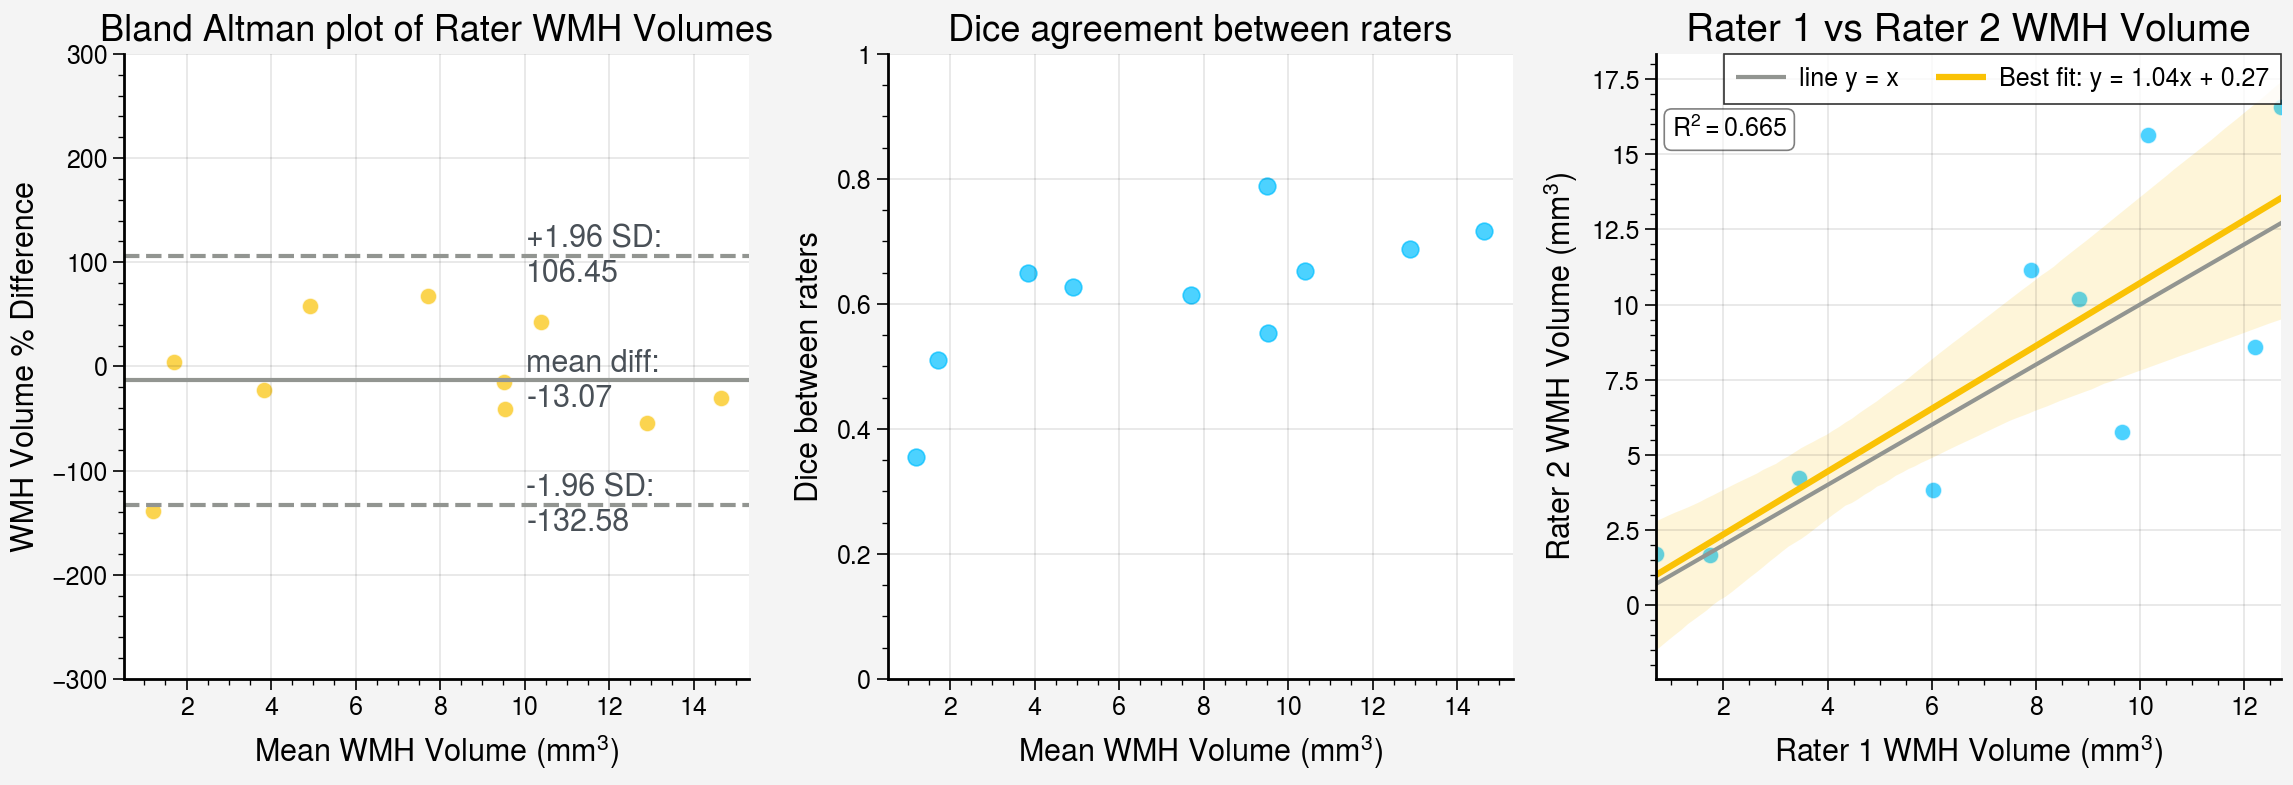

In [25]:
# spines and ticks
fig = pplt.figure(refwidth="25em", span=False, share=False)
axs = fig.subplots(nrows=1, ncols=3)

fontsize=11

x = df["WMH1_mm3"]
y = df["WMH2_mm3"]
bland_altman_plot(axs[0], x, y, fontsize)
axs[0].set_ylim((-300, 300))

y = df["DSC"]
x = (df["WMH1_mm3"] + df["WMH2_mm3"]) / 2
dice_agreement_plot(axs[1], x, y, fontsize)
axs[1].set_ylim((0, 1))

x = df["WMH1_mm3"].values
y = df["WMH2_mm3"].values
rater_volume_comparison(axs[2], x, y, fontsize)

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.)
    ax.spines['bottom'].set_linewidth(1.)
    plt.minorticks_on()
    ax.tick_params(axis='both', labelsize=fontsize-2)